# Name: Moseli Motsoehli
# ICS 674 Evolutionary computation

-----


# Introduction

While research in advancing the practical usability of most optimization algorithms such as machine learning models and genetic algorithms is at an all time high, the fact that results still depend heavily on initial hyper-parameters is often neglected and there is little work done in automating the search for these parameters. Most researchers and practitioners that are just starting out depend on intuitive guessing partly guided by the API documentation, however this is not sufficient as the objective function varies from problem to problem. More experienced users would have better intuition, and in most cases, more compute power to afford random search over their supposed search space<br>

<br>
It is for these reasons I decided to focus on automated hyper-parameter optimization for machine learning models.At this point in time I will only evolve a genetic algorithm on a scikit-learn(sklearn) neural network to get the best parameters for a specific dataset(breast cancer binary classification dataset). This work can be extended in the future to become a python library that wraps around any sklearn model trained on a arbitrary dataset for supervised(classification and regression) or unsupervised learning task. If such a library is developed so it scales well, it would provide for an alternative to the existing sklearn random grid search based methods for hyper-parameter optimization. <strong>Note: </strong><i>After a few days on this I found out there is an existing GA hyper-parameter tuner for sklearn models, however that does not harm  the need for this work as this can be a competing tuner, maybe better than the existing one, after all even GAs also have different parameters</i>.

-----

# Neural Networks

Artificial Neural networks are computational blocks whose architecture is inspired by the biological neurons. The general idea in neural networks is that: given a deep enough network consisting of neurons with non linear activations, and a sufficient number of examples, we can approximate any continuous function. A basic neural network consist of an input layer with as many neurons as the dimensionality of the independent variable in our data, a hidden layer with any number of neurons equipped with non-linearity functions(activations), and an output layer matching the dimensions of the dependent variable in our data. The more useful networks have multiple hidden layers. These networks are trained using back propagation of errors to adjust the network weights and this is controlled by gradient descent. The general performance depends largely on the network structure and other hyper-parameters.<br> 

<br>
Although there are a lot of hyper-parameters to tune in optimizing a neural network, this work only focuses on the following:<br>
<ul>
    <li>depth: number of hidden layers</li>
    <li>hidden_layer_sizes: The number of neurons in each layer</li>
    <li>activation: The non-linearity activation function to use in the hidden layers</li>
    <li>solver: optimization algorithm that is used to update network weights based in training data</li>
    <li>alpha: The L2 penalty regularization term to use</li>
    <li>learning_rate_init: The amount by which to allow each iteration/batch to affect the network weights</li>
    <li>learning_rate_structure: Whether to use a changing or constant learning rate</li>
    <li>max_iter: The number of training iterations over the entire dataset</li>
</ul>

# External Libraries and Dataset

The  breast cancer wisconsin dataset is a dataset containing 30 numeric features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. The label of each observation is an indicator of whether that represents a malignant cell or not. This dataset can be found at: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic). All the code is written in python due to its richness in useful libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import random
from tqdm import tqdm
from sklearn.datasets import load_breast_cancer
from sklearn.neural_network import MLPClassifier as NN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
import warnings
warnings.simplefilter("ignore")
import pickle

##############################################################################
# Load the breast cancer data and split into test and training then use a NN  #
##############################################################################
data = load_breast_cancer()
x_train,x_test,y_train,y_test = train_test_split(data.data, data.target, test_size=0.3,random_state=42)
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (398, 30)
x test:  (171, 30)
y train:  (398,)
y test:  (171,)


-----

# The Genetic Algorithm 

While neural networks mimic only one component of the biological neural system, genetic algorithms seek to mimic the evolutionary process of genes. The idea is that, starting out with a random population, random mutations and selective mating leads to individuals with a better genetic profile than earlier generations, and these later generations are more adapted to their environment than their ancestors. In the context of computational optimization, this means we can evolve an initial population of bad solution into very good solutions using the basic tools of evolution. For this work, this means I can start out with a population of neural networks with random hyper-parameters and evolve them to perform well on a predefined dataset. Below I describe the different components of my evolutionary algorithm and accompany them with code where possible<br> 

## Search space and Representation

The Search space for the evolutionary algorithm in this problem is very complex since neural networks initialize their weights from a non deterministic distribution and so the same network structure can have different results on the same dataset in two runs. The other thing that makes this problem complex is that this work does not focus on just parameter, and some of the parameters are on the continuous space. However, since only a finitely small(relative) number of NN models are explored to keep time and space complexity low, the problem is closer to the discreet space than it is continuous. Below are the ranges for all parameters to the neural networks that represent the search space.

<ul>
    <li>depth: $x \in \mathbb{Z}, x \in [2,150)$</li>
    <li>hidden_layer_sizes: $x \in \mathbb{Z}, x \in [50,200)$</li>
    <li>activation: {identity, logistic, tanh, relu}</li>
    <li>solver: {sgd, adam}</li>
    <li>alpha: $\alpha \in \mathbb{R}, \alpha \in (0,0.01)$</li>
    <li>learning_rate_init: $\lambda \in \mathbb{R}, \lambda \in (0.005)$</li>
    <li>learning_rate_structure: {constant, invscaling, adaptive}</li>
    <li>max_iter: $N \in \mathbb{Z}, N \in [50,150)$</li>
</ul>


In [2]:
class MLPerceptronClass:
    def __init__(self,randomize=True,params={}):
        if randomize==True:
            self.params = self.Random_individual()
        else:
            self.params = params
        self.model = NN(hidden_layer_sizes=self.params["hidden_layer_sizes"],
                        activation=self.params["activation"],
                        solver=self.params["solver"],
                        alpha=self.params["alpha"],
                        learning_rate=self.params["learning_rate"],
                        learning_rate_init=self.params["learning_rate_init"],
                        max_iter=self.params["max_iter"])
        
    def hidden_layer_sizes(self,layers):
        return layers
    
    def activation(self,activation):
        switch = {0:"identity",1:"logistic",2:"tanh",3:"relu"}
        return switch[activation]
    
    def solver(self,solver_num):
        switch = {0:"sgd",1:"adam"}
        return switch[solver_num]

    def alpha(self,alpha_num): #penalty term
        if alpha_num is not None:
            return alpha_num
        else:
            return np.random.random()/100
    
    def learning_rate_structure(self,lrs):
        switch = {0:"constant",1:"invscaling",2:"adaptive"}
        return switch[lrs]
    
    def learning_rate_init(self,lri):
        if lri is not None:
            return lri
        else:
            return np.random.random()/200
        
    def max_iter(self):
        return np.random.randint(50,150)
    
    def Random_individual(self):
        #hiddend layer 
        params={}
        layer_size = np.random.randint(50,200)
        num_layers =  np.random.randint(2,150)
        params["hidden_layer_sizes"] = (layer_size,num_layers)
        
        #activation
        params["activation"] = self.activation(np.random.randint(0,4))
        
        #solver
        params["solver"] = self.solver(np.random.randint(0,2))
        
        #alpha(L2 regularizer)
        params["alpha"] = self.alpha(np.random.random()/100)
    
        #learning_rate_structure
        params["learning_rate"] = self.learning_rate_structure(np.random.randint(0,3))
        
        #learning_rate_init
        params["learning_rate_init"] = self.learning_rate_init(np.random.random()/200)
        
        #max_iter
        params["max_iter"] =self.max_iter()
        return params

Each individual in the search space is represented by a MLPerceptronClass object with a dictionary of parameters. Due to fear of running out of time, I decided to use a conservative initial random population size of __50__ for the GA. Since the search space also contains continuous variables , I will not compare the time complexity of this model to a random search at this time as this would require thourough understanding of literature on discretization of such spaces and their complexity.

## Objective Function

In most GA tasks, the target is known but how to configure the elements of the search space to get to it is unknown. The objective or maximum performance possible using a NN on an arbitrary dataset is impractical (or even impossible), and so the goal is always to find the estimator that gives the best performance on a given metric amongst others within a reasonable complexity. In this work, the objective is to find the set of parameters that lead to the highest accuracy score. This metric can be interpreted as a measure of the proportion of correct classifications the model makes on an unseen dataset. The implementation in sklearn takes the true class labels and the model's predicted classes.<br>

Although the accuracy score theoretically has a global max of 1, in practice this might not always be possible given the data and probabilistic approximator. For this study I optimistically set the target mean accuracy score to $97\%$ since the default parameters gave a $91\%$ accuracy score, an improvement of $6\%$ is huge in machine learning.

## Variation Operators

Variation operators are used for both exploration and exploitation of the search space to ensure the GA is more likely to end up at the global optimum of the search space. The operators used here are: Mutation and crossover. Although these are sometimes fixed, I decided on a naive adaptive method of updating their probabilities so that earlier in the algorithm, there is more exploration through higher mutation, then later there is more crossover and less mutation to exploit the potential optimum. These values are controlled by the number of generations we have gone through..

## Selection Operator


From one generation to the other, first the fitness of all individuals is calculated by training a NN on that individual's parameters, then the accuracy score is calculated using a left out test dataset and the resulting figure represents the individual's fitness. The higher the better. An elitism function is then applied to the populationg, meaning the top $x\%$ fittest individuals move directly into the next generation. This propotion is changed adaptively as the evolutionary process continues so that it is higher in later generations. To make up the rest of the new generation, the variation operators are applied on the top $50\%$ of the current generation, this means in each generation the worst $50\%$ dies off. The mutation, elitism and crossover probabilities are slightly altered every 4 generations. The algorithm is said to have converged once a generation achives a mean accuracy score of $97\%$, or when the maxumum number of generations has been reached as I am aware it might be that it is impossible to reach such a score given the dataset.

In [3]:
class Genetic_Algorithm:
    def __init__(self,population_size,mutation_prob,elitism,crossover_prob):
        self.population_size = population_size
        self.mutation_prob = mutation_prob
        self.elitism = elitism
        self.crossover_prob = crossover_prob
        self.population = []
        self.new_population = []
        self.generation_params=[]
        self.fitness = {}
        self.target = 0.97
        self.max_gen = 100 
        self.decay_generations = 4
        
        
    def mutate(self):
        return random.choice(self.genes)
    
    #generates a valid random NN configuration within our parameter space
    def random_genome(self):
        Model_instance = MLPerceptronClass(True)
        return Model_instance.params
    
    #mating with crossover using adaptive mutation probs
    def mating(self,parent1,parent2):
        param_len = len(parent1)
        assert param_len == len(parent2),"Both parents should have the same gene count"
        offspring = {}
        for k in parent1:
            prob = random.random()
            if prob<=(1-self.mutation_prob)/2:
                offspring[k] = parent1[k]
            elif prob<=(1-self.mutation_prob):
                offspring[k] = parent2[k]
            else:
                offspring[k] = self.random_genome()[k]
        return offspring
    
    #AUC Score calc for fitness
    def calc_fitness(self,individual):
        model_eval = MLPerceptronClass(False,individual)
        model_eval.model.fit(x_train,y_train)
        y_pred = model_eval.model.predict(x_test)
        return accuracy_score(y_test, y_pred)
  
    #for adaptive probabilities, when called it will alter the existing probabilities
    def adaptive_probs(self):
        self.mutation_prob -= 0.002
        self.crossover_prob -= 0.01 
        self.elitism += 0.01
    
    #running the evolutionary algo
    def Main(self):
        
        #population init
        Converged = False
        Generation = 1;
        for k in range(self.population_size):
            self.population.append(self.random_genome())
            
        self.generation_params.append(self.population)
        #selection
        #pbar = tqdm(range(self.max_gen))
        while(Converged==False):
            print("----------Generation %s--------"%Generation)
            
            """calc fitness for current population and perform selection"""

            self.fitness["Generation %s"%Generation]= list(map(self.calc_fitness,self.population))
            sortedindexes =  list(np.flip(np.argsort(self.fitness["Generation %s"%Generation])))
            print("Best fitness: ",pd.Series(self.fitness["Generation %s"%Generation])[sortedindexes[0]])
            print("Average fitness: ",np.mean(self.fitness["Generation %s"%Generation]))
            print("Worst fitness: ",pd.Series(self.fitness["Generation %s"%Generation])[sortedindexes[-1]])
            
            """-elite top self.elitism% straight to new generation
                -cross over for other crossover_prob%, only within top 50% of previous population
                -new entrants for last (1-self.elitism-crossover_prob)% very small.
            """
            self.new_population.extend(list(pd.Series(self.population)[sortedindexes[:int(self.elitism*self.population_size)]]))
            self.new_population.extend([self.random_genome() for _ in range(int((1-self.crossover_prob-self.elitism)*self.population_size))])
            while(len(self.new_population)!=len(self.population)):
                """ Crossover from only the top 50% from previous population """
                p1=random.choice(list(pd.Series(self.population)[sortedindexes[:int(0.5*self.population_size)]]))
                p2=random.choice(list(pd.Series(self.population)[sortedindexes[:int(0.5*self.population_size)]]))
                self.new_population.append(self.mating(p1,p2))
            
            self.population=self.new_population
            self.new_population=[]
            #pbar.update(1)
            self.generation_params.append(self.population)
            #test convergence
            if np.mean(self.fitness["Generation %s"%Generation])>=self.target or Generation>=self.max_gen:
                Converged=True
                print("GA stopped after %s generations"%Generation)
            else:
                Generation+=1
                if Generation%self.decay_generations == 0:
                    self.adaptive_probs()
        #pbar.close()

-----

## Running the algorithm and save the progress

Save EA object with its parameters in the name for later comparison as I run multiple times with different mutation and crossover initial values.<br>
Parameters: population_size, mutation_prob, elitism, crossover_prob

In [ ]:
GA = Genetic_Algorithm(population_size = 50, mutation_prob = 0.4, elitism = 0.4, crossover_prob = 0.6)
GA.Main()
#save object  containing history and parameters
file_pi = open('mutation_prob_0.6_elitism_0.1_crossover_prob_0.9.obj', 'wb') 
pickle.dump(GA, file_pi,pickle.HIGHEST_PROTOCOL)

## Analysis

To analys the EA, I will look at the progress for the different runs of the EA with specific focus on the mean performance per generation, the max and the min. I will then go into the parameter space to see if there was a noticable shift in parameters as the generations evolved towards higher performance.

### Accuracy plots

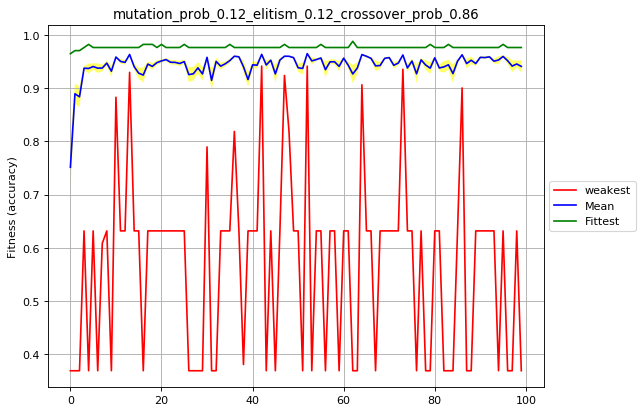

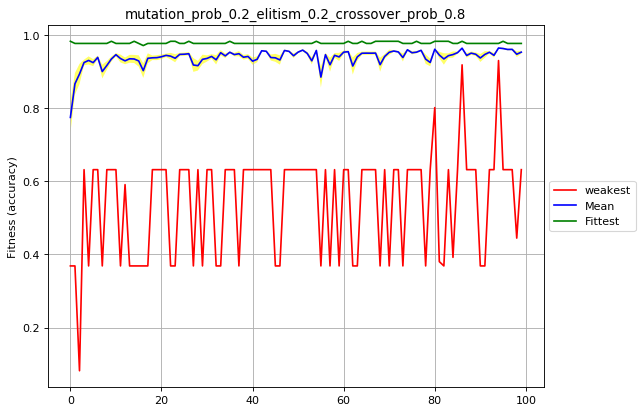

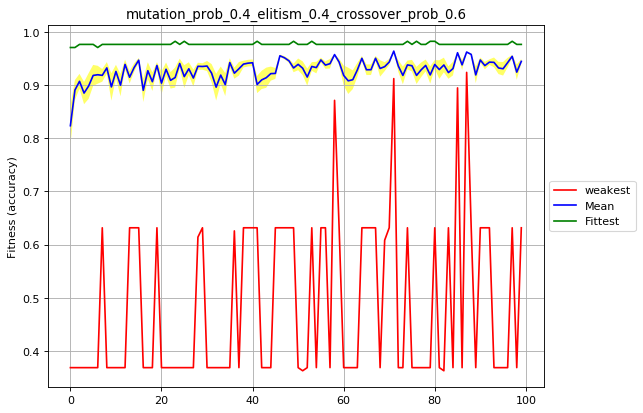

In [139]:
class Analytics:
    def __init__(self,Evolved_GA,configk):
        self.GA = Evolved_GA
        self.name = configk
        self.numeric = {}
        self.features ={"categorical":["activation","solver","learning_rate"],
                        "numeric":["hidden_layer_sizes","alpha","learning_rate_init","max_iter"]}
        self.fitness_plots()
    
    def fitness_plots(self):
        #find lowest, mean, max
        generations = list(range(len(self.GA.fitness)))
        weakest = [np.min(self.GA.fitness[k]) for k in self.GA.fitness]
        std_plus = [np.var(self.GA.fitness[k])+np.mean(self.GA.fitness[k]) for k in self.GA.fitness]
        std_minus = [-np.var(self.GA.fitness[k])+np.mean(self.GA.fitness[k]) for k in self.GA.fitness]
        average = [np.mean(self.GA.fitness[k]) for k in self.GA.fitness]
        fittest = [np.max(self.GA.fitness[k]) for k in self.GA.fitness]
        
        figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(generations, weakest,'r',label="weakest")
        plt.plot(generations, average,'b',label="Average")
        plt.plot(generations, fittest,'g',label="Fittest")
        plt.fill_between(generations,std_plus,std_minus,facecolor='yellow', alpha=0.6)
        plt.ylabel("Generation")
        plt.ylabel("Fitness (accuracy)")
        plt.legend(["weakest","Mean","Fittest"],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(self.name)
        plt.grid(True,which="both",axis="both")
        plt.show()
        
    def numeric_plot(self):
        asdf = pd.DataFrame(self.numeric)
        asdf.plot(kind="line", title="Mean parameter value through time", legend =True, subplots=True, figsize=(13, 8))
        print(feature)
        
    def categorical(self,feature):
        #results.features["categorical"]
        counts = {}
        numeric = {"hidden_layer_sizes":[],"max_iter":[],"num_layers":[],"L2_regularization":[]}
        for k in range(len(self.GA.generation_params)):
                numeric["hidden_layer_sizes"].append(0)
                numeric["max_iter"].append(0)
                numeric["num_layers"].append(0)
                numeric["L2_regularization"].append(0)
                for p in range(len(self.GA.generation_params[k])):
                    if self.GA.generation_params[k][p][feature] not in counts:
                        counts[self.GA.generation_params[k][p][feature]]=[]
                        counts[self.GA.generation_params[k][p][feature]].append(1)
                    else:
                        counts[self.GA.generation_params[k][p][feature]][-1]+=1
                    numeric["hidden_layer_sizes"][k] += self.GA.generation_params[k][p]["hidden_layer_sizes"][0]/50
                    numeric["max_iter"][k] += self.GA.generation_params[k][p]["max_iter"]/50
                    numeric["num_layers"][k] += self.GA.generation_params[k][p]["hidden_layer_sizes"][1]/50
                    numeric["L2_regularization"][k] += self.GA.generation_params[k][p]["alpha"]/50
                for k in counts:
                    counts[k].append(0)
        self.numeric=numeric      
        asdf = pd.DataFrame(counts)
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,figsize=(13, 6))
        ax1.set_xlabel("Gene frequency")
        ax2.set_xlabel("Generation")
        ax2.set_ylabel("Count")
        asdf.plot(kind="kde",title="Probability density curve for %s"%feature, legend =True, ax=ax1)
        asdf.plot(kind="area", title="Frequency of each %s through time"%feature, legend =True, ax=ax2,stacked=True)
        plt.show()
        
config = ["mutation_prob_0.12_elitism_0.12_crossover_prob_0.86",
          "mutation_prob_0.2_elitism_0.2_crossover_prob_0.8",
          "mutation_prob_0.4_elitism_0.4_crossover_prob_0.6"]
results=[]
for k in config:
    with open('%s.obj'%k, 'rb') as input:
        load_test = pickle.load(input)
    results.append(Analytics(load_test,k))

From The Plots above, We see there is an improvement in the mean performance of the population over the generations despite the frequent ups and downs caused by introducing new gene combinations through mutation. Another difference is in the variance of performance, marked by the yellow fill around the mean performance curve. The GA configuration with lower mutation probability also shows much lower variance throughout the Generations s compared to the much higher mutation probability GA. <br>

Changing elitism and mutation at the same time seems to musk the effects of elitism in the population and so to see it we would need to keep everything else constant. Another aspect that seems be counter my expectations is that the best performance is reached very early and never really improves substantially. However, I think letting the algorithm run longer could lead to an improvement and see the gap between mean performance and best performance shrink to one line asymptotically.<br>

-----

# Exploring the features

I will now look at the search space and see whether later generations consisted of any specific NN configuration more than the others. This would lead me to believe we were indeed approaching some local or global maximum in the search space.

### Activation Function

While there is a fixed probability initially of selection of any of the activation function, very quickly the logistic (sigmoid) activation function dominates the population. This is somewhat counter intuitive since research has shown that for deep learning you should use relu as it helps both for overfitting and acts as a non-linearity. However, the big assumption behind that statement is that you have tons of data, which we don't in this specific problem. 

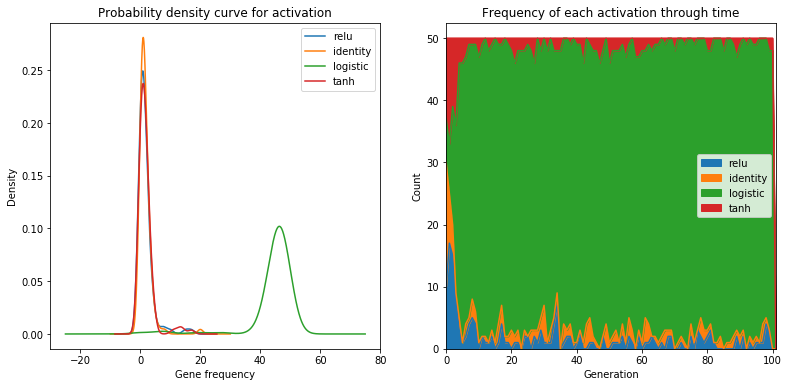

In [140]:
results[0].categorical("activation")

### Learning rate Stucture

The plot below shows no significant preference for a specific learning rate structure until the process stops, this means there was no significant enviromental benefits for prefering one over the other. Towards the end it looks like the adaptive and constant are dying off, but that can be a periodic trend as we see the same thing at around generation 20.

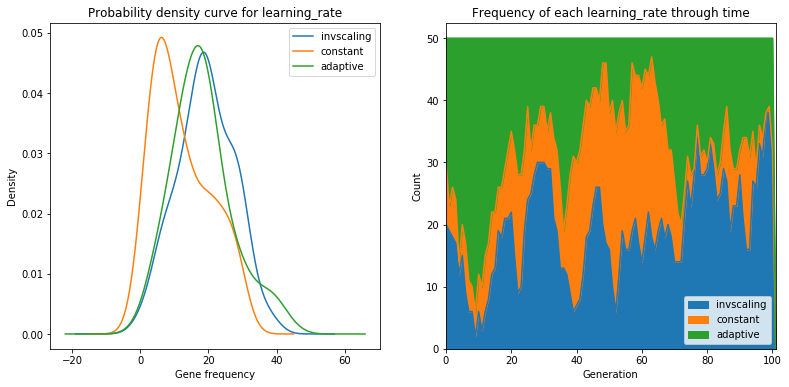

In [111]:
results[0].categorical("learning_rate")

### Solver

While there were only 2 options to pick from, theoretically being a two sided coin toss, it seems most of the individuals with the sgd gene hardly ever make it to next generations and "adam" slowly takes over.

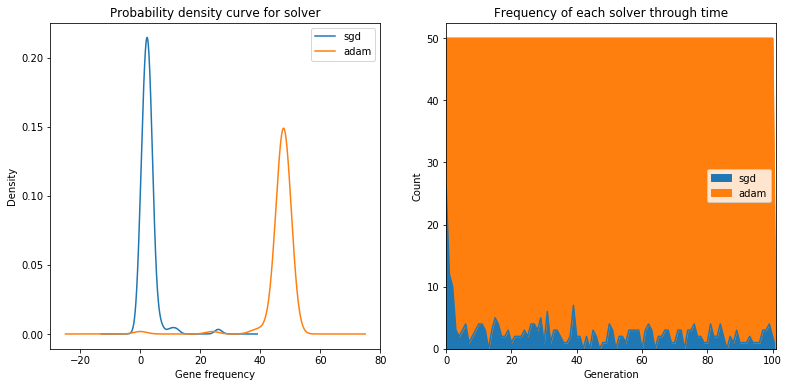

In [109]:
results[0].categorical("solver")

## Numerical Features

Below I plot the mean population parameter values to see if there is a trend through time towards lower or high parameter values

activation


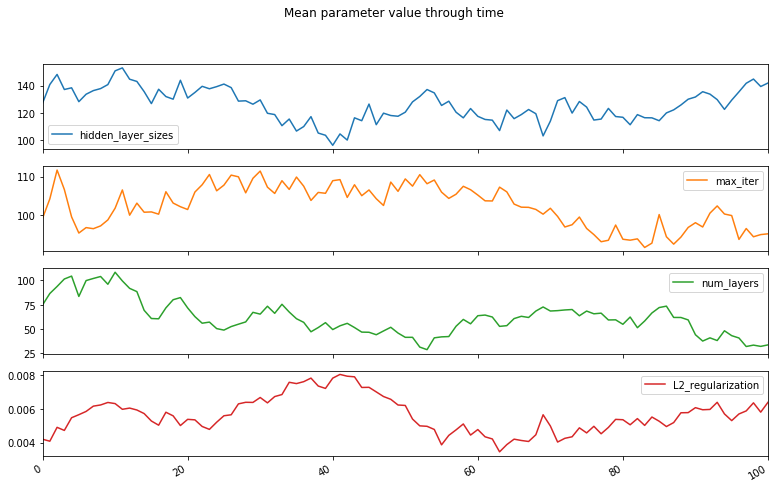

In [141]:
results[0].numeric_plot()

The Plots show again a move away from the "deep learning" neural network structure of stacking as many layers as you can and training for as long as we can as long as we have good regularization. In the plots above, the  mean number of iterations decreases with time and well as the mean number of hidden layers used. This could be a response to the fact that much larger networks trained longer on this small dataset will overfit the training set and perform poorly on the test set, which our fitness operator is based on. So to survive, smaller number of hidden layers are required so as to not overfit. different hidden layer size and penalty term were explored through the generations and it does not seem there is any one good range.d that statement is that you have tons of data, which we don't in this specific problem. 

# Conclusion

While the algorithm did not eventually get to $97\%$ mean accuracy (peaked at $96.2\%$) over a population of 50 in 100 generations, the improvement was still substantial and the method provided insight into the parameter space that could get the highest accuracy. Also, the time complexity of the algorithm is promising with more code optimization. I am keen to continue on extending this project to work for most if not all sklearn models and provide the type of analysis above. At the end of the search, I can atleast say that for this dataset, you will need a wide, not very deep neural network, trained using adam, with sigmoid activations, and only train for about 100 iterations using the default learning rate and regularization alphas. 

-----